In [1]:
import pandas as pd
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from langsmith import traceable
from langchain_openai import AzureChatOpenAI
import json
from langchain_core.prompts import ChatPromptTemplate
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
AZURE_OPENAI_API_KEY=os.environ["AZURE_OPENAI_API_KEY"]
AZURE_OPENAI_ENDPOINT=os.environ["AZURE_OPENAI_ENDPOINT"]
AZURE_OPENAI_API_VERSION=os.environ["AZURE_OPENAI_API_VERSION"]

In [ ]:
llm = AzureChatOpenAI(
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version=AZURE_OPENAI_API_VERSION,
    deployment_name="gpt-4o-mini",
    temperature=0.1
)

In [4]:
from pydantic import BaseModel, Field
from typing import List, Optional

class AgentState(BaseModel):
    user_query: str = Field(...)
    topics: Optional[List[str]] = None
    raw_explanations: Optional[List[str]] = None
    normalized_explanations: Optional[List[str]] = None
    final_answer: Optional[str] = None


In [5]:
@traceable(name="Topic Split Node")
def split_topics(state: AgentState):
    topics = [t.strip() for t in state.user_query.split(",")]
    return {"topics": topics}


In [6]:
@traceable(name="ExplainTopic Parallel Node")
def explain_topic_parallel(state: AgentState):
    outputs = []

    for topic in state.topics:
        prompt = f"Explain this topic simply: {topic}"
        response = llm.invoke(prompt)
        outputs.append(response.content)

    return {"raw_explanations": outputs}


In [7]:
@traceable(name="Normalize Explanations Node")
def normalize_outputs(state: AgentState):
    normalized = []
    for text in state.raw_explanations:
        prompt = f"Convert this explanation into 3 bullet points:\n{text}"
        response = llm.invoke(prompt)
        normalized.append(response.content)

    return {"normalized_explanations": normalized}


In [8]:
@traceable(name="Merg Answer Node")
def merge_results(state: AgentState):
    merged = "\n\n".join(state.normalized_explanations)
    return {"final_answer": merged}


In [9]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("split", split_topics)
workflow.add_node("parallel_explain", explain_topic_parallel)
workflow.add_node("normalize", normalize_outputs)
workflow.add_node("merge", merge_results)

workflow.set_entry_point("split")

workflow.add_edge("split", "parallel_explain")
workflow.add_edge("parallel_explain", "normalize")
workflow.add_edge("normalize", "merge")
workflow.add_edge("merge", END)

graph = workflow.compile()


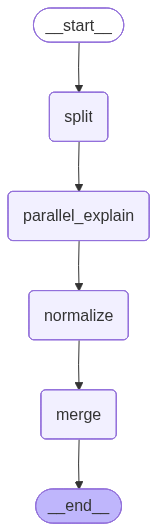

In [10]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
result = graph.invoke({
    "user_query": "Neural Networks, Overfitting, Regularization"
})

ChatGoogleGenerativeAIError: Error calling model 'gemini-2.0-flash' (RESOURCE_EXHAUSTED): 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_input_token_count, limit: 0, model: gemini-2.0-flash\n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 0, model: gemini-2.0-flash\n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 0, model: gemini-2.0-flash\nPlease retry in 2.919847479s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_input_token_count', 'quotaId': 'GenerateContentInputTokensPerModelPerMinute-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.0-flash'}}, {'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.0-flash'}}, {'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerDayPerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.0-flash'}}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '2s'}]}}

In [ ]:
print(result["topics"])

In [ ]:
print(result["raw_explanations"])

In [ ]:
print(result["normalized_explanations"])

In [ ]:
print(result["final_answer"])